In [ ]:
#####--------------------------------------------------------------------#####
##### PREPARATION
#####--------------------------------------------------------------------#####
import pandas as pd
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
from typing import List, Union, Optional, Callable
import pickle
from Bio import AlignIO, SeqIO
from ete3 import Tree, TreeNode
from gctree import CollapsedTree

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import umap
from ete3 import Tree, faces, TreeStyle, NodeStyle, TextFace, SequenceFace, COLOR_SCHEMES, CircleFace
from GCTree_preparation import *
import warnings
import math
from matplotlib.patches import Rectangle
warnings.filterwarnings("ignore")

tqdm.pandas()
from collections import Counter

path_to_storage = "/media/hieunguyen/HNHD01/storage/all_BSimons_datasets"
outdir = "/media/hieunguyen/GSHD_HN01/outdir/sc_bulk_BCR_data_analysis_v0.1"

PROJECT = "220701_etc_biopsies"
path_to_main_output = f"{outdir}/tree_analysis/{PROJECT}"
path_to_01_output = os.path.join(path_to_main_output, "01_output")
path_to_08_output = os.path.join(path_to_main_output, "08_output")
os.system(f"mkdir -p {path_to_08_output}")

output_type = "mouse_based_output"

path_to_trees = os.path.join(path_to_storage, PROJECT, "GCtrees/v0.2", output_type)

all_tree_folder = [item for item in pathlib.Path(path_to_trees).glob("*") if 
                   os.path.isfile(f"{str(item)}/02_dnapars/gctree.out.inference.1.nk") == True]

all_nk_files = [item for item in pathlib.Path(path_to_trees).glob("*/*/*gctree.out.inference.1.nk")]  
print(f"Number of trees: {len(all_tree_folder)}")   

path_to_metadata = "/media/hieunguyen/HNSD01/src/sc_bulk_BCR_data_analysis/preprocessing/220701_etc_biopsies/metadata.csv"
mid_metadata = pd.read_csv(path_to_metadata, sep =";")
mid_metadata = mid_metadata.drop(['Unnamed: 6', 'Unnamed: 7'], axis = 1)
mid_metadata.columns = ['MID', 'mouse', 'age', 'day', 'population', 'label', 'hex color']

##### Re run the summary analysis of all trees and rendering tree figures
# rerun = True
rerun = False

path_to_04_output = os.path.join(outdir, "VDJ_output", "04_output")
thres = 0.85

clonedf = pd.read_csv(os.path.join(path_to_04_output, "full_clonedf_with_mutation_rate.csv"), index_col= [0])
clonedf = clonedf[clonedf['num_mutation'] != "region_not_covered-skip"]
clonedf = clonedf[clonedf['dataset.name'] == "220701_etc_biopsies"]

maindf = pd.read_csv(f"{path_to_01_output}/tree_summarydf.csv")

def get_tree_sum_abundance(x):
    mouseid = x.split("_")[0]
    path_to_save_tree_svg = os.path.join(path_to_01_output, mouseid)
    os.system(f"mkdir -p {path_to_save_tree_svg}")

    treeobj = saveTreeobj[x] 

    idmapdf = treeobj.idmapseqdf.copy()
    seqdf = treeobj.seqdf.copy()
    seqdf["population"] = seqdf["MID"].apply(lambda x: mid_metadata[mid_metadata["MID"] == x]["population"].values[0])
    seqdf = seqdf.merge(idmapdf, right_on = "seq", left_on = "seq")
    abd = seqdf.abundance.sum()
    return abd

tqdm.pandas()
# Reload the dictionary from the pickle file
with open(f"{path_to_01_output}/saveTreeobj.pkl", "rb") as f:
    saveTreeobj = pickle.load(f)
if os.path.isfile(f"{path_to_01_output}/tree_summarydf.addedAbundance.csv") == False:
    maindf["clone_sum_abundance"] = maindf["cloneid"].progress_apply(lambda x: get_tree_sum_abundance(x))
    maindf["pct_sum_abundance"] = maindf[["clone_sum_abundance", "mouseID"]].progress_apply(lambda x: x[0]/maindf[maindf["mouseID"] == x[1]]["clone_sum_abundance"].sum(), axis = 1)
    maindf = maindf.sort_values(by=  "pct_sum_abundance", ascending = False)
    maindf.to_csv(f"{path_to_01_output}/tree_summarydf.addedAbundance.csv", index=False)
else:
    maindf = pd.read_csv(f"{path_to_01_output}/tree_summarydf.addedAbundance.csv")
color_path = "./hex_color.csv"

/home/hieunguyen/miniconda3/envs/ete3_py39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# ##### analysis example for 1 tree. 
# cloneid = "m30_IGHV1-82-01_IGHJ2-01_30_1.aln"

# mouseid = cloneid.split("_")[0]
# path_to_save_tree_svg = os.path.join(path_to_01_output, mouseid)
# os.system(f"mkdir -p {path_to_save_tree_svg}")

# treeobj = saveTreeobj[cloneid] 
# avai_mids = treeobj.seqdf["MID"].unique()
# mid_color_pal = pd.read_csv(color_path, index_col = [0]).to_dict()["hex color"]

# ts = treeobj.generate_tree_style(color_path = color_path)
# # treeobj.tree.render("%%inline", tree_style=ts) 

# for input_mid in avai_mids:
#     if input_mid == "GL":
#         input_mid_col = "gray"
#     else:
#         input_mid_col = mid_color_pal[input_mid]
#     ts.legend.add_face(CircleFace(10, input_mid_col), column = 0)
#     ts.legend.add_face(TextFace(input_mid), column = 0)

# idmapdf = treeobj.idmapseqdf.copy()
# seqdf = treeobj.seqdf.copy()
# seqdf["population"] = seqdf["MID"].apply(lambda x: mid_metadata[mid_metadata["Unnamed: 0"] == x]["population"].values[0])
# seqdf = seqdf.merge(idmapdf, right_on = "seq", left_on = "seq")
# treeobj.tree.render(f"%%inline", tree_style=ts) 

def plot_tree_inline(cloneid):
    mouseid = cloneid.split("_")[0]
    path_to_save_tree_svg = os.path.join(path_to_01_output, mouseid)
    os.system(f"mkdir -p {path_to_save_tree_svg}")

    treeobj = saveTreeobj[cloneid] 
    avai_mids = treeobj.seqdf["MID"].unique()
    mid_color_pal = pd.read_csv(color_path, index_col = [0]).to_dict()["hex color"]

    ts = treeobj.generate_tree_style(color_path = color_path)
    # treeobj.tree.render("%%inline", tree_style=ts) 

    for input_mid in avai_mids:
        if input_mid == "GL":
            input_mid_col = "gray"
        else:
            input_mid_col = mid_color_pal[input_mid]
        ts.legend.add_face(CircleFace(10, input_mid_col), column = 0)
        ts.legend.add_face(TextFace(input_mid), column = 0)

    idmapdf = treeobj.idmapseqdf.copy()
    seqdf = treeobj.seqdf.copy()
    seqdf["population"] = seqdf["MID"].apply(lambda x: mid_metadata[mid_metadata["MID"] == x]["population"].values[0])
    seqdf = seqdf.merge(idmapdf, right_on = "seq", left_on = "seq")
    # treeobj.tree.render(f"%%inline", tree_style=ts) 
    # plt.show()
    return treeobj, ts


In [ ]:
from itertools import combinations
population_combinations = []
for i in range(1, len(mid_metadata.population.unique()) + 1):
    population_combinations.extend(combinations(mid_metadata.population.unique(), i))
all_populations = [",".join(item) for item in population_combinations]

In [ ]:
#####-------------------------------------------------------------#####
##### Generate nodedf: summary all features of nodes
#####-------------------------------------------------------------#####
rerun = True
if os.path.isfile(os.path.join(path_to_08_output, "nodedf.csv")) == False or rerun == True:
    '''
    Help on method get_distance in module ete3.coretype.tree:
    get_distance(target, target2=None, topology_only=False) method of ete3.coretype.tree.TreeNode instance
        Returns the distance between two nodes. If only one target is
        specified, it returns the distance between the target and the
        current node.
        
        :argument target: a node within the same tree structure.
        
        :argument target2: a node within the same tree structure. If
        not specified, current node is used as target2.
        
        :argument False topology_only: If set to True, distance will
        refer to the number of nodes between target and target2.
        
        :returns: branch length distance between target and
        target2. If topology_only flag is True, returns the number
        of nodes between target and target2.
    '''
    nodedf = pd.DataFrame()
    all_trees = list(saveTreeobj.keys())
    for cloneid in tqdm(all_trees):
        mouseid = cloneid.split("_")[0]
        path_to_save_tree_svg = os.path.join(path_to_01_output, mouseid)
        os.system(f"mkdir -p {path_to_save_tree_svg}")

        treeobj = saveTreeobj[cloneid] 

        idmapdf = treeobj.idmapseqdf.copy()
        seqdf = treeobj.seqdf.copy()
        seqdf["population"] = seqdf["MID"].apply(lambda x: mid_metadata[mid_metadata["MID"] == x]["population"].values[0])
        seqdf = seqdf.merge(idmapdf, right_on = "seq", left_on = "seq")

        df = pd.DataFrame(data = seqdf.seqid.unique(), columns = ["seqid"])
        df["mouseid"] = mouseid
        df["cloneID"] = cloneid
        df["population"] = df["seqid"].apply(lambda x: ",".join(seqdf[seqdf["seqid"] == x]["population"].unique()) 
                                            if len(seqdf[seqdf["seqid"] == x]["population"].unique()) > 1 else seqdf[seqdf["seqid"] == x]["population"].values[0])
        df["abundance"] = df["seqid"].apply(lambda x: seqdf[seqdf["seqid"] == x]["abundance"].sum())
        df["MID"] = df["seqid"].apply(lambda x: ",".join(seqdf[seqdf["seqid"] == x]["MID"].values) 
                                            if len(seqdf[seqdf["seqid"] == x]["MID"].unique()) > 1 else seqdf[seqdf["seqid"] == x]["MID"].values[0])
        df["mixed_node"] = df["population"].apply(lambda x: "yes" if "," in x else "no")

        df["dist_to_root"] = df["seqid"].apply(lambda x: treeobj.node_depth(node = [item for item in treeobj.nodes if item.name == x][0], topo = False))
        df["topo_dist_to_root"] = df["seqid"].apply(lambda x: treeobj.node_depth(node = [item for item in treeobj.nodes if item.name == x][0], topo = True))

        deepest_node = df[df["dist_to_root"] == df["dist_to_root"].max()].seqid.unique()[0]

        df["dist_to_deepest"] = df["seqid"].apply(lambda x: treeobj.tree.get_distance(x, deepest_node) if x != deepest_node else 0)
        df["topo_dist_to_deepest"] = df["seqid"].apply(lambda x: treeobj.tree.get_distance(x, deepest_node, topology_only= True) if x != deepest_node else 0)

        # heatmap_plotdf = df[["seqid",'population', "mixed_node", 'dist_to_root', 'dist_to_deepest']]
        # heatmap_plotdf["population"] = heatmap_plotdf[["population", "mixed_node", "seqid"]].apply(lambda x: "_".join(x), axis = 1)
        # heatmap_plotdf = heatmap_plotdf.drop(["mixed_node", "seqid"], axis = 1).set_index("population")
        # plt.figure(figsize= (10, 15))
        # sns.heatmap(heatmap_plotdf, cmap="coolwarm", cbar=-1, linewidths=0.5, linecolor='black')
        # for tick_label in plt.gca().get_yticklabels():
        #     tick_text = tick_label.get_text()
        #     if "yes" in tick_text:
        #         tick_label.set_color('red')
        #     elif "biopsy" in tick_text:
        #         tick_label.set_color('blue')
        #     else:
        #         tick_label.set_color('black')
                
        df["population2"] = df["population"].apply(lambda x: "biopsy" if x == "biopsy" else "other")
        min_val = dict()
        max_val = dict()
        mean_val = dict()

        for dist_type in ["dist_to_root", "dist_to_deepest"]:
            min_val[dist_type] = dict()
            max_val[dist_type] = dict()
            mean_val[dist_type] = dict()
            for group in df.population2.unique():
                min_val[dist_type][group] = df.groupby("population2")[dist_type].min()[group]
                max_val[dist_type][group] = df.groupby("population2")[dist_type].max()[group]
                mean_val[dist_type][group] = df.groupby("population2")[dist_type].mean()[group]
        df["parent_node"] = df["seqid"].apply(lambda x: treeobj.tree.search_nodes(name=x)[0].up.name)

        df["parent_node_type"] = df["parent_node"].apply(lambda x: seqdf[seqdf["seqid"] == x]["population"].values[0] if x in seqdf["seqid"].values else "inferred_node")

        #####------------------------------------------------------------------------------------#####
        ##### Calculate Shannon entropy of nodes in a neighborhood of a node
        #####------------------------------------------------------------------------------------#####

        def calculate_population_entropy_in_neighborhood(input_populations, type = "global"):
            '''
            function to calculate shannon entropy of nodes in the neighborhood of a node.  
            '''
            countdf = pd.DataFrame(data = input_populations.split(","), columns = ["population"]).reset_index()
            countdf = countdf.groupby("population")["index"].count().reset_index()
            if type == "global":
                populationdf = pd.DataFrame(data = all_populations, columns = ["population"])
                populationdf["count"] = populationdf["population"].apply(lambda x: countdf[countdf["population"] == x]["index"].values[0] if x in countdf["population"].values else 0)
                sum_count = populationdf["count"].sum()
                shannon_entropy = -1 * np.sum([(item/sum_count)*(np.log(item/sum_count)) for item in populationdf["count"].values if item != 0])/np.log(len(all_populations))
            elif type == "local":
                sum_count = countdf["index"].sum()
                shannon_entropy = -1 * np.sum([(item/sum_count)*(np.log(item/sum_count)) for item in countdf["index"].values if item != 0])/np.log(countdf.shape[0])
            else: 
                raise ValueError("type must be either global or local")
            return shannon_entropy
        
        for dist_cutoff in [3,5,10]:
            distdf = pd.DataFrame(df.seqid.unique(), columns = ["seqid"])
            for seq2 in distdf.seqid.unique():
                distdf[seq2] = distdf["seqid"].apply(lambda x: treeobj.tree.get_distance(x, seq2, topology_only= True) if x != seq2 else 0)

            all_seqs = [item for item in distdf.columns if item != "seqid" and "seq" in item]
            distdf[f"neighbor_nodes_{dist_cutoff}"] = distdf[all_seqs].apply(
                lambda x: ",".join([all_seqs[item] for item in [i for i,j in enumerate(x) if j <= dist_cutoff]]) , axis = 1
            )
            distdf[f"neighbor_type{dist_cutoff}"] = distdf[f"neighbor_nodes_{dist_cutoff}"].apply(
                lambda x: ",".join([df[df["seqid"] == item]["population"].unique()[0] for item in x.split(",")])
            )
            distdf[f"shannon_entropy_global_{dist_cutoff}"] = distdf[f"neighbor_type{dist_cutoff}"].apply(
                lambda x: calculate_population_entropy_in_neighborhood(x, type = "global")
            )
            distdf[f"most_frequent_type_{dist_cutoff}"] = distdf[f"neighbor_type{dist_cutoff}"].apply(
                lambda x: Counter(x.split(",")).most_common(1)[0][0]
            )
            df = df.merge(distdf[["seqid", 
                                f"neighbor_nodes_{dist_cutoff}", 
                                f"neighbor_type{dist_cutoff}", 
                                f"shannon_entropy_global_{dist_cutoff}", 
                                f"most_frequent_type_{dist_cutoff}"]], 
                                right_on = "seqid", 
                                left_on = "seqid")
        #####------------------------------------------------------------------------------------#####
        ##### Distance from a node to its furthest child-node
        #####------------------------------------------------------------------------------------#####
        def get_node_furthest_child(x, topo):
            output = treeobj.tree.search_nodes(name=x)[0].get_farthest_leaf(topology_only= topo)
            return output[0].name, output[1]
        df[['topo_furthest_child_node', 'topo_dist_to_furthest_child_node']] = df['seqid'].apply(
            lambda x: pd.Series(
                get_node_furthest_child(x, True)))
        df[['furthest_child_node', 'dist_to_furthest_child_node']] = df['seqid'].apply(
            lambda x: pd.Series(
                get_node_furthest_child(x, False)))

        #####------------------------------------------------------------------------------------#####
        ##### merge to final nodedf dataframe
        #####------------------------------------------------------------------------------------#####
        nodedf = pd.concat([nodedf, df], axis = 0)
    nodedf["age"] = nodedf["mouseid"].apply(lambda x: mid_metadata[mid_metadata["mouse"] == x]["age"].unique()[0])
    nodedf["day"] = nodedf["mouseid"].apply(lambda x: mid_metadata[mid_metadata["mouse"] == x]["day"].unique()[0])
    nodedf["age_day"] = nodedf[["age", "day"]].apply(lambda x: f"{x[0]}_{x[1]}", axis = 1)
    nodedf.to_csv(os.path.join(path_to_08_output, "nodedf.csv"), index = False)
else:
    nodedf = pd.read_csv(os.path.join(path_to_08_output, "nodedf.csv"))



<Axes: xlabel='population', ylabel='shannon_entropy_global_5'>

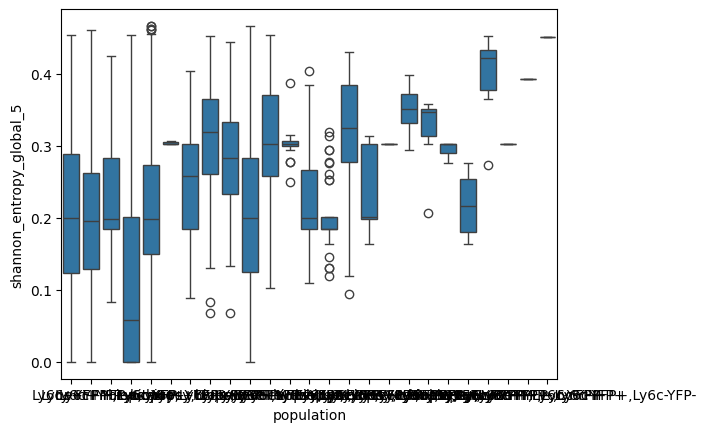

In [ ]:
sns.boxplot(data = nodedf, x = "population", y = "shannon_entropy_global_5")

<Axes: xlabel='age', ylabel='topo_dist_to_root'>

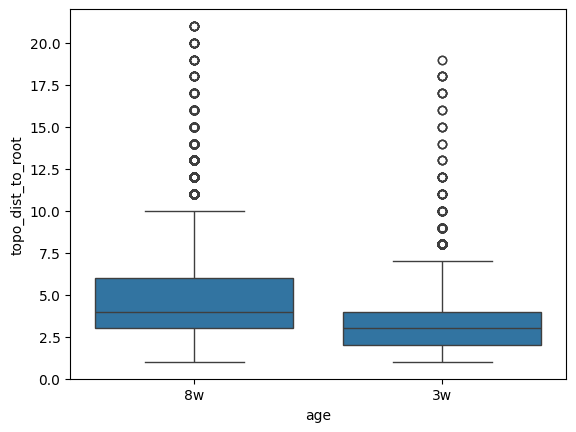

In [ ]:
sns.boxplot(data = nodedf[nodedf["population"] == "biopsy"], x = "age", y = "topo_dist_to_root")